In [12]:
import pandas as pd
import torch

from netam import framework, models

import sys
sys.path.append('..')
from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname

In [2]:
shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
df = pd.read_csv(shmoof_path)

df = df[df["parent"] != df["child"]]

frac_long_seqs = (df["parent"].str.len() > 410).sum() / len(df)
print(f"Fraction of long sequences: {frac_long_seqs:.2g}")

Fraction of long sequences: 0.0036


In [3]:
df["sample_id"].value_counts()

sample_id
326651    22424
326713    13186
327059     4686
316188     3067
326797     3028
326780     1573
326737      442
326650      324
326907      286
Name: count, dtype: int64

In [4]:
# set nickname to be the last two characters of sample_id
df["nickname"] = df["sample_id"].astype(str).str[-2:]

for small_nickname in ["80", "37", "50", "07"]:
    df.loc[df["nickname"] == small_nickname, "nickname"] = "small"

nicknames = df["nickname"].unique()

df["nickname"].value_counts()

nickname
51       22424
13       13186
59        4686
88        3067
97        3028
small     2625
Name: count, dtype: int64

In [9]:
train_losses = []
val_losses = []

kmer_length=5
site_count=500
shmoof_data_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"

for nickname in nicknames:
    train_df, val_df = load_shmoof_dataframes(shmoof_data_path, val_nickname=nickname)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

    print(f"evaluating on {nickname}...")
    model = models.SHMoofModel(kmer_length, site_count)
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-4, l2_regularization_coeff=1e-6)
    train_losses.append(burrito.process_data_loader(train_loader, train_mode=False))
    val_losses.append(burrito.process_data_loader(val_loader, train_mode=False))

df = pd.DataFrame({"nickname of val set": nicknames, "train_loss": train_losses, "val_loss": val_losses})
df
    

evaluating on 88...
evaluating on small...
evaluating on 97...
evaluating on 59...
evaluating on 51...
evaluating on 13...


,nickname of val set,train_loss,val_loss
0,88,tensor(0.0835),tensor(0.0655)
1,small,tensor(0.0874),tensor(0.0763)
2,97,tensor(0.0869),tensor(0.0775)
3,59,tensor(0.0874),tensor(0.0796)
4,51,tensor(0.0891),tensor(0.0907)
5,13,tensor(0.0829),tensor(0.0954)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def mutation_count_of_row(row):    
    return sum(
        1 for p, c in zip(row["parent"], row["child"]) if p != c and p != "N" and c != "N"
    )    

mutation_counts = {nickname: [] for nickname in nicknames}

for nickname in nicknames:
    _, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname)  # Load the dataframe
    val_df['mutation_count'] = val_df.apply(mutation_count_of_row, axis=1)
    mutation_counts[nickname] = val_df['mutation_count'].tolist()

tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
mutation_counts["tang"] = tang_df.apply(mutation_count_of_row, axis=1)


Loading /Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv.gz


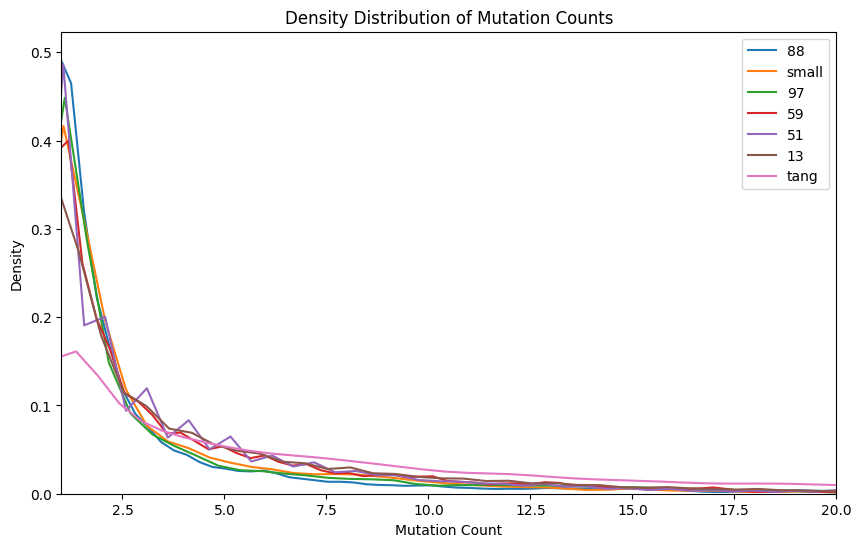

In [14]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for nickname, counts in mutation_counts.items():
    sns.kdeplot(counts, label=nickname, bw_adjust=0.5)

plt.xlim(1, 20)
plt.xlabel('Mutation Count')
plt.ylabel('Density')
plt.title('Density Distribution of Mutation Counts')
plt.legend()
plt.show()
